# Understanding Covid-19 through College Data
> Author: Miles Franklin<br>
> Instructor: Dr. John Wan<br>
> School: University of Maryland Baltimore County<br>
> Course: DATA 601

## Motivating Question:
How many students and employees of Universities have been infected with Covid-19 while operation on campus?

### Hypothesis 1: 
Schools in states with less strict mask restrictions will have higher rates. This will require additional data gathering

### Hypothesis 2: 
Schools case rate should be proportional to school size. This would imply that each school has roughly the same occupacy rate on campus. This will require additional data gathering for school size data.

# 1. Imports

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

# !pip install --upgrade seaborn
import seaborn as sns
print(sns.__version__)

0.11.0


# 2. Reading in Data

## 2.1 Reading in Base Data Frame

In [2]:
# https://github.com/nytimes/covid-19-data/blob/master/colleges/colleges.csv
url_base = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/colleges/colleges.csv"

df_base = pd.read_csv(url_base, sep=",")
display(df_base)

,date,state,county,city,ipeds_id,college,cases,notes
0,2020-11-05,Alabama,Madison,Huntsville,100654.0,Alabama A&M University,41.0,NaN
1,2020-11-05,Alabama,Montgomery,Montgomery,100724.0,Alabama State University,NaN,NaN
2,2020-11-05,Alabama,Limestone,Athens,100812.0,Athens State University,23.0,NaN
3,2020-11-05,Alabama,Lee,Auburn,100858.0,Auburn University,2047.0,NaN
4,2020-11-05,Alabama,Montgomery,Montgomery,100830.0,Auburn University at Montgomery,80.0,NaN
...,...,...,...,...,...,...,...,...
1768,2020-11-05,Wisconsin,Milwaukee,Milwaukee,240338.0,Wisconsin Lutheran College,34.0,NaN
1769,2020-11-05,Wyoming,Natrona,Casper,240505.0,Casper College,185.0,NaN
1770,2020-11-05,Wyoming,Goshen,Torrington,240596.0,Eastern Wyoming College,6.0,NaN
1771,2020-11-05,Wyoming,Albany,Laramie,240727.0,University of Wyoming,1012.0,NaN


## 2.2 Reading in NCAA Data Frame

In [3]:
url_wiki_ncaa = "https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_institutions"

r = requests.get(url_wiki_ncaa)
soup = BeautifulSoup(r.text)

df_ncaa = pd.read_html(str(soup.find_all("table")[0]))[0]
# display(df_ncaa)

## 2.3 Reading in Mask Data Frame
The first url_mask variable is the page that I found the data from. On the bottom of that link is a hyperlink, [Source: Masks4All](https://www.datawrapper.de/_/AD5p1/), but I was unable to use bs4 to scrape either page. So, the data was downloaded into csv_mask.

In [4]:
url_mask = "https://masks4all.co/what-states-require-masks/"
url_mask = "https://www.datawrapper.de/_/AD5p1/"
csv_mask = "data-AD5p1.csv"

df_mask = pd.read_csv(csv_mask)

# Splitting State. into State and url
temp = df_mask["State."].str.split(']', expand=True)
temp.columns = ["State", "url"]

temp["State"] = temp["State"].apply(lambda x: x[1:])
temp["url"] = temp["url"].apply(lambda x: x[1:-1])

df_mask = df_mask.merge(temp, left_index=True, right_index=True)
df_mask = df_mask.drop(columns=["State."])

# Renaming Territory to State in Mask Required?
df_mask["Masks Required?"] = df_mask["Masks Required?"].apply(lambda x: x.replace("Territory", "State"))

# Rename Requirement Date Column Name
df_mask = df_mask.rename(columns={'Requirement Date':'Initial Mask Requirement Date'})

# with pd.option_context('display.max_colwidth', 400):
# display(df_mask)

## 2.4 Reading in Governor Data Frame

In [5]:
url_wiki_governors = "https://en.wikipedia.org/wiki/List_of_United_States_governors"

r = requests.get(url_wiki_governors)
soup = BeautifulSoup(r.text)

df_gov_list = []
df_gov_list.append( pd.read_html(str(soup.find_all("table")[0]))[0] ) # States
df_gov_list.append( pd.read_html(str(soup.find_all("table")[1]))[0] ) # Territories
df_gov_list.append( pd.read_html(str(soup.find_all("table")[2]))[0] ) # District

# From Multi-Index to Index
for i in range(len(df_gov_list)):
    temp_cols = []
    for c in df_gov_list[i].columns:
        temp_cols.append( c[1] )
    df_gov_list[i].columns = temp_cols
    
# Merging Gov Data Frames
df_gov = pd.concat([df_gov_list[0],
                    df_gov_list[1].rename(columns={'Territory':'State'}),
                    df_gov_list[2].rename(columns={'Federal district':'State'})], ignore_index=True)

df_gov = df_gov.drop(columns=["Portrait", "Party", "Past governors", "Unnamed: 10_level_1", "Mayor", "Past mayors"])

# Clean Party.1 Column
df_gov = df_gov.rename(columns={'Party.1':'Party'})

df_gov.loc[22, "Party"] = "Democratic"
df_gov.loc[47, "Party"] = "Republican"
df_gov.loc[50, "Party"] = "Democratic"
df_gov.loc[53, "Party"] = "Republican"

# Split End of Term
df_gov["Has Term Lmits"] = df_gov["End of term"].apply(lambda x: 1 if len(str(x)) > 4 else 0)
df_gov["End of term"] = df_gov["End of term"].apply(lambda x: str(x)[:4])

# display(df_gov)

## 2.5 Loop through college names to scrape wiki fact table
https://en.wikipedia.org/wiki/Alabama_A%26M_University

In [6]:
# <table class="infobox vcard" style="width:22em">
all_col_names = ['Motto', 'Type', 'Established', 'Endowment', 'President', 'Students', 
           'Postgraduates', 'Location', 'Campus', 'Colors', 'Athletics', 'Nickname',
           'Affiliations', 'Sports', 'Mascot', 'Website']
col_names = ['Type', 'Endowment', 'Students', 'Postgraduates', 'Campus', 'Athletics', 'Sports']

url_wiki_base = "https://en.wikipedia.org/wiki/"
df_college_info = pd.DataFrame(columns=["college"]+col_names)

for college in df_base["college"].tolist():
    try:
        url_ = url_wiki_base + college
        r_ = requests.get(url_)
        print(college, "Request Status", r_.status_code)
        # print("url_", url_)
        soup_ = BeautifulSoup(r_.text)

        # print("len", len(soup_.find_all("table", {"class":"infobox vcard"})))
        table_ = soup_.find("table", {"class":"infobox vcard"})

        df_ = pd.read_html(str(table_))[0]
        df_.columns = ["col_name", "data"]
        # display(df_)

        dict_ = {}
        dict_["college"] = college
        for col in col_names:
            try:
                dict_[col] = [df_.iloc[df_.col_name.tolist().index(col), 1]]
            except:
                pass

        df_college_info = df_college_info.append(pd.DataFrame(dict_), ignore_index=True)
    except:
        print(url_)
    

display(df_college_info)

    

Alabama A&M University Request Status 200
Alabama State University Request Status 200
Athens State University Request Status 200
Auburn University Request Status 200
Auburn University at Montgomery Request Status 200
Bevill State Community College Request Status 200
Birmingham-Southern College Request Status 200
Calhoun Community College Request Status 200
Central Alabama Community College Request Status 200
Enterprise State Community College Request Status 200
Gadsden State Community College Request Status 200
Huntingdon College Request Status 200
Jacksonville State University Request Status 200
Lurleen B. Wallace Community College Request Status 200
Marion Military Institute Request Status 200
Miles College Request Status 200
Samford University Request Status 200
Snead State Community College Request Status 200
Southern Union State Community College Request Status 200
Spring Hill College Request Status 200
Troy University Request Status 200
Troy University Dothan Request Status 404
h

University of San Francisco Request Status 200
University of Southern California Request Status 200
University of the Pacific Request Status 200
https://en.wikipedia.org/wiki/University of the Pacific
Westmont College Request Status 200
Whittier College Request Status 200
Adams State University Request Status 200
Arapahoe Community College Request Status 200
Colorado Christian University Request Status 200
Colorado College Request Status 200
Colorado Mesa University Request Status 200
Colorado Mountain College Glenwood Springs Request Status 404
https://en.wikipedia.org/wiki/Colorado Mountain College Glenwood Springs
Colorado School of Mines Request Status 200
Colorado State University Request Status 200
Colorado State University-Pueblo Request Status 200
Community College of Denver Request Status 200
Fort Lewis College Request Status 200
Front Range Community College Request Status 200
Johnson & Wales University-Denver Request Status 404
https://en.wikipedia.org/wiki/Johnson & Wales U

Rasmussen College at Fort Myers Request Status 404
https://en.wikipedia.org/wiki/Rasmussen College at Fort Myers
Rollins College Request Status 200
Saint Leo University Request Status 200
Santa Fe College Request Status 200
Seminole State College of Florida Request Status 200
South Florida State College Request Status 200
Southeastern College at West Palm Beach Request Status 404
https://en.wikipedia.org/wiki/Southeastern College at West Palm Beach
Southeastern University Request Status 200
St. Johns River State College Request Status 200
St. Petersburg College Request Status 200
St. Thomas University Request Status 200
https://en.wikipedia.org/wiki/St. Thomas University
State College of Florida, Manatee-Sarasota Request Status 200
Stetson University Request Status 200
Strayer University at Fort Lauderdale Request Status 404
https://en.wikipedia.org/wiki/Strayer University at Fort Lauderdale
Tallahassee Community College Request Status 200
The College of the Florida Keys Request Status

Purdue University - Purdue Polytechnic Columbus Request Status 404
https://en.wikipedia.org/wiki/Purdue University - Purdue Polytechnic Columbus
Purdue University - Purdue Polytechnic Indianapolis Request Status 404
https://en.wikipedia.org/wiki/Purdue University - Purdue Polytechnic Indianapolis
Purdue University - Purdue Polytechnic Kokomo Request Status 404
https://en.wikipedia.org/wiki/Purdue University - Purdue Polytechnic Kokomo
Purdue University - Purdue Polytechnic Lafayette Request Status 404
https://en.wikipedia.org/wiki/Purdue University - Purdue Polytechnic Lafayette
Purdue University - Purdue Polytechnic New Albany Request Status 404
https://en.wikipedia.org/wiki/Purdue University - Purdue Polytechnic New Albany
Purdue University - Purdue Polytechnic Richmond Request Status 404
https://en.wikipedia.org/wiki/Purdue University - Purdue Polytechnic Richmond
Purdue University - Purdue Polytechnic South Bend Request Status 404
https://en.wikipedia.org/wiki/Purdue University - P

Southeastern Louisiana University Request Status 200
Southern University Law Center Request Status 200
https://en.wikipedia.org/wiki/Southern University Law Center
Southern University and A&M College Request Status 200
Southern University at New Orleans Request Status 200
Tulane University of Louisiana Request Status 200
University of Louisiana Monroe Request Status 200
University of Louisiana at Lafayette Request Status 200
University of New Orleans Request Status 200
Bates College Request Status 200
Bowdoin College Request Status 200
Colby College Request Status 200
Husson University Request Status 200
Maine Maritime Academy Request Status 200
Saint Joseph's College of Maine Request Status 200
Thomas College Request Status 200
University of Maine Request Status 200
University of Maine Farmington Request Status 200
University of Maine at Augusta Request Status 200
University of Maine at Fort Kent Request Status 200
University of Maine at Machias Request Status 200
University of Maine 

Crown College Request Status 200
https://en.wikipedia.org/wiki/Crown College
Dakota County Technical College Request Status 200
Fond du Lac Tribal and Community College Request Status 200
Gustavus Adolphus College Request Status 200
Hamline University Request Status 200
Hennepin Technical College Request Status 200
Hibbing Community College Request Status 200
Inver Hills Community College Request Status 200
Itasca Community College Request Status 200
Lake Superior College Request Status 200
Macalester College Request Status 200
Martin Luther College Request Status 200
Mesabi Range College Request Status 200
Mesabi Range College Request Status 200
Metropolitan State University Request Status 200
Minneapolis Community and Technical College Request Status 200
Minnesota State College Southeast Request Status 200
https://en.wikipedia.org/wiki/Minnesota State College Southeast
Minnesota State Community and Technical College Request Status 200
Minnesota State University Moorhead Request Statu

Montclair State University Request Status 200
New Jersey City University Request Status 200
New Jersey Institute of Technology Request Status 200
Princeton University Request Status 200
Ramapo College of New Jersey Request Status 200
Rider University Request Status 200
Rowan University Request Status 200
Rutgers University Request Status 200
Saint Peter's University Request Status 200
Seton Hall University Request Status 200
Stevens Institute of Technology Request Status 200
Stockton University Request Status 200
The College of New Jersey Request Status 200
Thomas Edison State University Request Status 200
William Paterson University Request Status 200
Eastern New Mexico University Request Status 200
Institute of American Indian Arts Request Status 200
Navajo Technical University Request Status 200
New Mexico Highlands University Request Status 200
New Mexico Institute of Mining and Technology Request Status 200
New Mexico Military Institute Request Status 200
New Mexico State Universi

Trocaire College Request Status 200
Ulster County Community College Request Status 200
Union College Request Status 200
United States Merchant Marine Academy Request Status 200
United States Military Academy West Point Request Status 404
https://en.wikipedia.org/wiki/United States Military Academy West Point
University of Rochester Request Status 200
Upstate Medical University Request Status 200
Utica College Request Status 200
Vassar College Request Status 200
Wagner College Request Status 200
Weill Cornell Medical College Request Status 200
Wells College Request Status 200
Yeshiva University Request Status 200
Appalachian State University Request Status 200
Barton College Request Status 200
Belmont Abbey College Request Status 200
Brevard College Request Status 200
Campbell University Request Status 200
Carolinas College of Health Sciences Request Status 200
https://en.wikipedia.org/wiki/Carolinas College of Health Sciences
Catawba College Request Status 200
Chowan University Request

Oklahoma Panhandle State University Request Status 200
Oklahoma State University Request Status 200
Oklahoma State University Center for Health Sciences Request Status 200
Oklahoma State University Institute of Technology Request Status 200
Oklahoma State University-Oklahoma City Request Status 200
Oral Roberts University Request Status 200
Rogers State University Request Status 200
Rose State College Request Status 200
Southeastern Oklahoma State University Request Status 200
Southern Nazarene University Request Status 200
Southwestern Oklahoma State University Request Status 200
University of Central Oklahoma Request Status 200
University of Oklahoma Request Status 200
University of Science and Arts of Oklahoma Request Status 200
University of Tulsa Request Status 200
Eastern Oregon University Request Status 200
George Fox University Request Status 200
Lane Community College Request Status 200
Lewis & Clark College Request Status 200
Linfield University Request Status 200
Linfield Un

Widener University Request Status 200
Wilkes University Request Status 200
Wilson College Request Status 200
https://en.wikipedia.org/wiki/Wilson College
York College of Pennsylvania Request Status 200
Colegio Universitario de San Juan Request Status 404
https://en.wikipedia.org/wiki/Colegio Universitario de San Juan
Conservatory of Music of Puerto Rico Request Status 200
Escuela de Artes Plasticas y Diseno de Puerto Rico Request Status 404
https://en.wikipedia.org/wiki/Escuela de Artes Plasticas y Diseno de Puerto Rico
University of Puerto Rico Request Status 200
Brown University Request Status 200
Bryant University Request Status 200
Johnson & Wales University Request Status 200
Providence College Request Status 200
Rhode Island College Request Status 200
Rhode Island School of Design Request Status 200
Roger Williams University Request Status 200
Salve Regina University Request Status 200
University of Rhode Island Request Status 200
Anderson University Request Status 200
https://en

The University of the South Request Status 200
Trevecca Nazarene University Request Status 200
Tusculum University Request Status 200
Union University Request Status 200
University of Memphis Request Status 200
University of Tennessee Health Science Center Request Status 200
University of Tennessee at Chattanooga Request Status 200
University of Tennessee at Martin Request Status 200
University of Tennessee, Knoxville Request Status 200
Vanderbilt University Request Status 200
Volunteer State Community College Request Status 200
Walters State Community College Request Status 200
Abilene Christian University Request Status 200
Angelo State University Request Status 200
Austin College Request Status 200
Austin Community College District Request Status 200
Baylor University Request Status 200
Blinn College Request Status 200
Brazosport College Request Status 200
Collin College McKinney Request Status 404
https://en.wikipedia.org/wiki/Collin College McKinney
Concordia University Texas Requ

Bellingham Technical College Request Status 200
Cascadia College Request Status 200
Central Washington University Request Status 200
Centralia College Request Status 200
Clark College Request Status 200
Clover Park Technical College Request Status 200
https://en.wikipedia.org/wiki/Clover Park Technical College
Columbia Basin College Request Status 200
Eastern Washington University Request Status 200
Edmonds College Request Status 200
Everett Community College Request Status 200
Evergreen State College Request Status 200
Gonzaga University Request Status 200
Grays Harbor College Request Status 200
Green River College Request Status 200
Highline College Request Status 200
Lake Washington Institute of Technology Request Status 200
Lower Columbia College Request Status 200
North Seattle College Request Status 200
Northwest Indian College Request Status 200
Olympic College Request Status 200
Pacific Lutheran University Request Status 200
Peninsula College Request Status 200
https://en.wikip

,college,Type,Endowment,Students,Postgraduates,Campus,Athletics,Sports
0,Alabama A&M University,Public historically black land-grant university,$48.0 million (2019)[2],"6,001 (Fall 2018)[3]",963 (Fall 2018)[3],"Suburban, 880 acres (3.6 km2)",NCAA Division I FCSSouthwestern Athletic Confe...,15 Varsity sports
1,Alabama State University,"Public, HBCU",$101 million (2017)[1],5475,NaN,"Urban, 172-acres[2]",NaN,NaN
2,Athens State University,Public,NaN,3500,NaN,NaN,NaN,NaN
3,Auburn University,Public flagship land-grant research university,$793.0 million (2019)[1],"30,440 (Fall 2018)[5]","5,812 (Fall 2018)[5]","College town, 1,841 acres (7.45 km2)[5]",NaN,NaN
4,Auburn University at Montgomery,Public,$24 million[1],"5,211 (Fall 2018)[3]",579 (Fall 2018)[3],"Suburban, 500 acres (2 km2)",NCAA Division II,NaN
...,...,...,...,...,...,...,...,...
1538,Wisconsin Lutheran College,Private,$36.6 million (2019)[1],"1,188 approx.",NaN,"Suburban, 40 acres (16 ha)",18 NCAA Division III teams,NaN
1539,Casper College,Public community college,NaN,4023,NaN,NaN,NaN,NaN
1540,Eastern Wyoming College,Community College,NaN,1505,NaN,"Torrington, Wyoming and Douglas, Wyoming",NaN,NaN
1541,University of Wyoming,Public flagshipLand grant,$515.1 million (2019)[1],"12,450 (Fall 2018)[5]",452 (Fall 2018)[5],Small city,NCAA Division I – MWC,NaN


## 2.6 Merge df_gov["Party"] onto df_base

In [7]:
df = df_base.merge(df_gov[["Party", "State"]], left_on='state', right_on='State')
df = df.merge(df_mask[["Masks Required?", "Initial Mask Requirement Date", "State"]], on='State')

df = df.drop(columns=["state", "county", "city", "ipeds_id", "notes"])
df = df.rename(columns={'date':'date_cases'})

display(df)

,date_cases,college,cases,Party,State,Masks Required?,Initial Mask Requirement Date
0,2020-11-05,Alabama A&M University,41.0,Republican,Alabama,Entire State,7/16/2020
1,2020-11-05,Alabama State University,NaN,Republican,Alabama,Entire State,7/16/2020
2,2020-11-05,Athens State University,23.0,Republican,Alabama,Entire State,7/16/2020
3,2020-11-05,Auburn University,2047.0,Republican,Alabama,Entire State,7/16/2020
4,2020-11-05,Auburn University at Montgomery,80.0,Republican,Alabama,Entire State,7/16/2020
...,...,...,...,...,...,...,...
1755,2020-11-05,Wisconsin Lutheran College,34.0,Democratic,Wisconsin,Entire State,8/1/2020
1756,2020-11-05,Casper College,185.0,Republican,Wyoming,Parts of State,NaN
1757,2020-11-05,Eastern Wyoming College,6.0,Republican,Wyoming,Parts of State,NaN
1758,2020-11-05,University of Wyoming,1012.0,Republican,Wyoming,Parts of State,NaN


# 3. Saving Data

## 3.1 As of 2020-10-24

In [77]:
# df.to_csv("data.csv", index=False)

## 3.2 As of 2020-11-15

In [9]:
# df.to_csv("data_2.csv", index=False)

## 3.3 For Future Runs

In [9]:
df.to_csv("data_3.csv", index=False)

# 4. Visualizing Data

## 4.1 Graphing PDF: Cases by Party Leadership 

Cases in colleges in Republican led states: 149,168.0
Cases in colleges in Democratic led states: 105,203.0
Avg number of cases per colleges in Republican led states: 197.84
Avg number of cases per colleges in Democratic led states: 113.49


/opt/anaconda3/envs/Python_and_R/lib/python3.8/site-packages/seaborn/distributions.py:948: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/anaconda3/envs/Python_and_R/lib/python3.8/site-packages/seaborn/distributions.py:991: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
/opt/anaconda3/envs/Python_and_R/lib/python3.8/site-packages/seaborn/distributions.py:948: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/anaconda3/envs/Python_and_R/lib/python3.8/site-packages/seaborn/distributions.py:991: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be rem

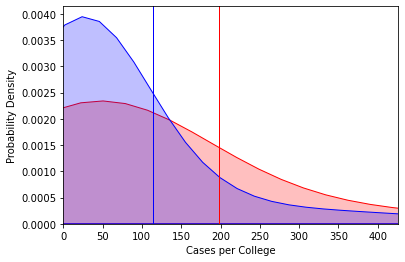

In [10]:
# df_subset_rep = df[ (df["Party"]=="Republican") ]
# df_subset_dem = df[ (df["Party"]=="Democratic") ]

print("Cases in colleges in Republican led states: {:,}".format(df.loc[(df['Party']=='Republican'), 'cases'].sum()))
print("Cases in colleges in Democratic led states: {:,}".format(df.loc[(df['Party']=='Democratic'), 'cases'].sum()))
print("Avg number of cases per colleges in Republican led states: {:,}".format(round(df.loc[(df['Party']=='Republican'), 'cases'].mean(), 2)))
print("Avg number of cases per colleges in Democratic led states: {:,}".format(round(df.loc[(df['Party']=='Democratic'), 'cases'].mean(), 2)))

# Estimated PDF
# df_subset_rep.cases.plot.kde()
sns.kdeplot(df.loc[(df['Party']=='Republican'), 'cases'], color='r', shade=True, Label='Republican') 
sns.kdeplot(df.loc[(df['Party']=='Democratic'), 'cases'], color='b', shade=True, Label='Democratic') 
  
# Setting the X and Y Label 
plt.xlabel('Cases per College') 
plt.ylabel('Probability Density')

# Plot Veritcal Line at Mean
plt.axvline(x=df.loc[(df['Party']=='Republican'), 'cases'].mean(), linewidth=1, color='r', label='Republican Mean')
plt.axvline(x=df.loc[(df['Party']=='Democratic'), 'cases'].mean(), linewidth=1, color='b', label='Democratic Mean')

# Limit x-axis view
# plt.xlim(left=df.cases.min(), right=df.cases.mean()+1*df.cases.std())
plt.xlim(left=df.cases.min(), 
         right=df.loc[(df['Party']=='Democratic'), 'cases'].mean() + 1*df.loc[(df['Party']=='Democratic'), 'cases'].std())


plt.show()

/opt/anaconda3/envs/Python_and_R/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/Python_and_R/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


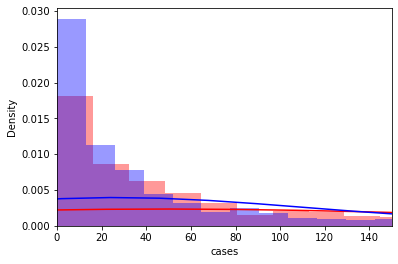

In [11]:
sns.distplot(df.loc[(df['Party']=='Republican'), 'cases'], bins=300, color='r', label='Republican') 
sns.distplot(df.loc[(df['Party']=='Democratic'), 'cases'], bins=300, color='b', label='Democratic')

plt.xlim(left=df.cases.min(), 
         right=150)
plt.show()

## 4.2 Graphing PDF's by State Mask order wide Oder

Number of states with entire state mask requirements: 35
Number of states with partial state mask requirements: 14
Number of states with no state mask requirements: 2

Cases in colleges with entire state mask requirements: 177,775.0
Cases in colleges with partial state mask requirements: 69,595.0
Cases in colleges with no state mask requirements: 7,001.0

Avg number of cases per colleges with entire state mask requirements: 137.6
Avg number of cases per colleges with partial state mask requirements: 188.6
Avg number of cases per colleges with no state mask requirements: 350.05


/opt/anaconda3/envs/Python_and_R/lib/python3.8/site-packages/seaborn/distributions.py:948: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/anaconda3/envs/Python_and_R/lib/python3.8/site-packages/seaborn/distributions.py:991: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
/opt/anaconda3/envs/Python_and_R/lib/python3.8/site-packages/seaborn/distributions.py:948: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/opt/anaconda3/envs/Python_and_R/lib/python3.8/site-packages/seaborn/distributions.py:991: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be rem

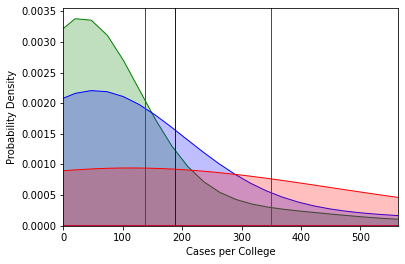

In [12]:
df_subset_A = df[ (df["Masks Required?"]=="Entire State") |
                  (df["Masks Required?"]=="Entire State (Employees Only)") |
                  (df["Masks Required?"]=="Entire State (Most Indoor Public Places)")]

df_subset_B = df[ (df["Masks Required?"]=="Parts of State") |
                  (df["Masks Required?"]=="Parts of State (Employees Only)") ]

df_subset_C = df[ (df["Masks Required?"]=="No") |
                  (df["Masks Required?"]=="Masks strongly recommended, provides masks for free") ]

# len(df_subset_A["State"].unique())

print("Number of states with entire state mask requirements: {:,}".format(len(df_subset_A["State"].unique())))
print("Number of states with partial state mask requirements: {:,}".format(len(df_subset_B["State"].unique())))
print("Number of states with no state mask requirements: {:,}".format(len(df_subset_C["State"].unique())))
print()

print("Cases in colleges with entire state mask requirements: {:,}".format(df_subset_A["cases"].sum()))
print("Cases in colleges with partial state mask requirements: {:,}".format(df_subset_B["cases"].sum()))
print("Cases in colleges with no state mask requirements: {:,}".format(df_subset_C["cases"].sum()))
print()

print("Avg number of cases per colleges with entire state mask requirements: {:,}".format(round(df_subset_A["cases"].mean(), 2)))
print("Avg number of cases per colleges with partial state mask requirements: {:,}".format(round(df_subset_B["cases"].mean(), 2)))
print("Avg number of cases per colleges with no state mask requirements: {:,}".format(round(df_subset_C["cases"].mean(), 2)))

# Estimated PDF
# df_subset_rep.cases.plot.kde()
sns.kdeplot(df_subset_A["cases"], color='g', shade=True, Label='Entire State Mask Order') 
sns.kdeplot(df_subset_B["cases"], color='b', shade=True, Label='Partial State Mask Order') 
sns.kdeplot(df_subset_C["cases"], color='r', shade=True, Label='No State Mask Order') 
  
# Setting the X and Y Label 
plt.xlabel('Cases per College') 
plt.ylabel('Probability Density')

# Plot Veritcal Line at Mean
plt.axvline(x=df_subset_A["cases"].mean(), linewidth=1, color='g', label='Entire State Mask Order Mean')
plt.axvline(x=df_subset_B["cases"].mean(), linewidth=1, color='b', label='Partial State Mask Order Mean')
plt.axvline(x=df_subset_C["cases"].mean(), linewidth=1, color='r', label='No State Mask Order Mean')

# Limit x-axis view
plt.xlim(left=df.cases.min(), right=df.cases.mean()+1*df.cases.std())

plt.show()

In [13]:
df_state_1 = pd.DataFrame(df.groupby("State")["cases"].sum())
df_state_1.columns = ["cases_sum"]
df_state_2 = pd.DataFrame(df.groupby("State")["cases"].mean())
df_state_2.columns = ["cases_mean"]

df_state = pd.merge(left=df_state_1, right=df_state_2, 
                    left_on='State', right_on='State', 
                    suffixes=('_sum', '_mean'))
df_state = df_state.apply(lambda x: round(x,2))
display(df_state)

,cases_sum,cases_mean
State,,
Alabama,9858.0,352.07
Alaska,105.0,35.00
Arizona,5690.0,711.25
Arkansas,5236.0,218.17
California,5224.0,63.71
Colorado,3937.0,151.42
Connecticut,2171.0,103.38
Delaware,646.0,92.29
Florida,13650.0,151.67


In [14]:
print("Cases in US Colleges (Sum):", "{:,}".format(df_state.cases_sum.sum()))
print("Avg cases by state:", "{:,}".format(round(df_state.cases_sum.mean(),2)))

Cases in US Colleges (Sum): 254,371.0
Avg cases by state: 4,987.67


# 4. Future Direction: Is the number of cases predictable?
> While I was interested in applying a model to the data scraped, this was not the primary goal of this assignment. Hence, there is not enough data present to train, or predict on each college in isolation. Moving forward, I would like to scrape some of the data from [here](https://www.collegedata.com/college/University-of-Alabama/) to get more information for this model. (i.e. Number of Undergraduate Students, Number of Graduate Students, Number of Full-Time Faculty Teaching Undergraduates, City Population, Percent of Students in College Housing (Typically), Demographic Distributions) The code below, is merely a step in preparation for this goal, rather than its execution.

## 4.1 Import for ML Model

In [ ]:
# from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

## 4.2 Prepping data for ML model

In [73]:
df_tree = df[df["cases"].notna()]
df_tree.loc[df_tree["Initial Mask Requirement Date"].isna(), "Initial Mask Requirement Date"] = "10/22/2020" 
df_tree = df_tree.drop(columns=["date_cases", "college"])

# Converting Categorical Columns

# Party
party_cat = pd.CategoricalDtype(categories=set(df_tree["Party"]), ordered=False)
df_tree["Party"] = df_tree["Party"].astype(party_cat)
df_tree["Party"] = df_tree["Party"].cat.codes

# State
state_cat = pd.CategoricalDtype(categories=set(df_tree["State"]), ordered=False)
df_tree["State"] = df_tree["State"].astype(state_cat)
df_tree["State"] = df_tree["State"].cat.codes

# Masks Required?
required = ['No', 'Parts of State (Employees Only)', 'Parts of State',
         'Masks strongly recommended, provides masks for free',
         'Entire State (Employees Only)', 'Entire State (Most Indoor Public Places)',
         'Entire State']
required_cat = pd.CategoricalDtype(categories=required, ordered=True)
df_tree["Masks Required?"] = df_tree["Masks Required?"].astype(required_cat)
df_tree["Masks Required?"] = df_tree["Masks Required?"].cat.codes

# Initial Mask Requirement Date
import datetime
def days_from_Jan_1_2020(x):
    month = int(x.split("/")[0])
    day   = int(x.split("/")[1])
    year  = int(x.split("/")[2])
    
    d = datetime.date(year, month, day)
    
    first_date = datetime.date(2020, 1, 1)
    row_date = d
    
    delta = row_date - first_date
    return delta.days

df_tree["Initial Mask Requirement Date"] = df_tree["Initial Mask Requirement Date"].apply(days_from_Jan_1_2020)

df_tree

/opt/anaconda3/envs/Python_and_R/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,cases,Party,State,Masks Required?,Initial Mask Requirement Date
0,41.0,0,45,6,197
2,23.0,0,45,6,197
3,2047.0,0,45,6,197
4,80.0,0,45,6,197
5,4.0,0,45,6,197
...,...,...,...,...,...
1755,34.0,1,18,6,213
1756,185.0,0,44,2,295
1757,6.0,0,44,2,295
1758,1012.0,0,44,2,295


In [74]:
X = df_tree.drop(columns=["cases"])
Y = df_tree.cases

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=2020)

## 4.3 Determining Model Hyper-parameters

In [75]:
# model = tree.DecisionTreeRegressor(random_state=2020)#, max_leaf_nodes = 2*len(X.columns))
model = tree.DecisionTreeClassifier(random_state=2020)#, max_leaf_nodes = 2*len(X.columns))

# Searching for best Model
num_features = len(X_train.columns)
grid = {"max_leaf_nodes": [num_features, num_features**2, num_features**3, num_features**4],
        "max_depth": [num_features, num_features*2, num_features*3, num_features*4, num_features*5, num_features*6]}
grid_search_cv = GridSearchCV(estimator = model, 
                              param_grid = grid, 
                              cv = 10, 
                              return_train_score = True, 
                              verbose = 2)

# print(model.get_params().keys())
grid_search_cv.fit(X_train, Y_train)

pd.DataFrame(grid_search_cv.cv_results_ ).sort_values(by=["mean_test_score", "std_test_score"], ascending = False).T

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] max_depth=4, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=4, max_leaf_nodes=4, total=   0.1s
[CV] max_depth=4, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=4, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=4, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=4, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=4, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=4, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4 ...................................
[CV] .........

/opt/anaconda3/envs/Python_and_R/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................... max_depth=4, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=16 ..................................
[CV] ................... max_depth=4, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=16 ..................................
[CV] ................... max_depth=4, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=16 ..................................
[CV] ................... max_depth=4, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=16 ..................................
[CV] ................... max_depth=4, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=16 ..................................
[CV] ................... max_depth=4, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=16 ..................................
[CV] ................... max_depth=4, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=16 ..................................
[CV] .

[CV] .................. max_depth=8, max_leaf_nodes=256, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=256 .................................
[CV] .................. max_depth=8, max_leaf_nodes=256, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=256 .................................
[CV] .................. max_depth=8, max_leaf_nodes=256, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=256 .................................
[CV] .................. max_depth=8, max_leaf_nodes=256, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=256 .................................
[CV] .................. max_depth=8, max_leaf_nodes=256, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=256 .................................
[CV] .................. max_depth=8, max_leaf_nodes=256, total=   0.0s
[CV] max_depth=12, max_leaf_nodes=4 ..................................
[CV] ................... max_depth=12, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=12, max_leaf_nodes=4 ..................................
[CV] .

[CV] .................. max_depth=16, max_leaf_nodes=64, total=   0.1s
[CV] max_depth=16, max_leaf_nodes=64 .................................
[CV] .................. max_depth=16, max_leaf_nodes=64, total=   0.0s
[CV] max_depth=16, max_leaf_nodes=64 .................................
[CV] .................. max_depth=16, max_leaf_nodes=64, total=   0.0s
[CV] max_depth=16, max_leaf_nodes=64 .................................
[CV] .................. max_depth=16, max_leaf_nodes=64, total=   0.0s
[CV] max_depth=16, max_leaf_nodes=64 .................................
[CV] .................. max_depth=16, max_leaf_nodes=64, total=   0.0s
[CV] max_depth=16, max_leaf_nodes=64 .................................
[CV] .................. max_depth=16, max_leaf_nodes=64, total=   0.0s
[CV] max_depth=16, max_leaf_nodes=256 ................................
[CV] ................. max_depth=16, max_leaf_nodes=256, total=   0.0s
[CV] max_depth=16, max_leaf_nodes=256 ................................
[CV] .

[CV] .................. max_depth=24, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=24, max_leaf_nodes=16 .................................
[CV] .................. max_depth=24, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=24, max_leaf_nodes=16 .................................
[CV] .................. max_depth=24, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=24, max_leaf_nodes=16 .................................
[CV] .................. max_depth=24, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=24, max_leaf_nodes=16 .................................
[CV] .................. max_depth=24, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=24, max_leaf_nodes=16 .................................
[CV] .................. max_depth=24, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=24, max_leaf_nodes=16 .................................
[CV] .................. max_depth=24, max_leaf_nodes=16, total=   0.0s
[CV] max_depth=24, max_leaf_nodes=16 .................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    3.5s finished


,10,11,14,15,18,19,22,23,1,2,...,4,8,12,16,20,5,9,13,17,21
mean_fit_time,0.00476685,0.00605216,0.0100517,0.00627661,0.00830557,0.009357,0.012644,0.00749743,0.00640202,0.00519874,...,0.00484686,0.00447156,0.00402701,0.00598187,0.0068486,0.00513973,0.00510411,0.00480072,0.00534925,0.00801158
std_fit_time,0.000627264,0.000916789,0.0122425,0.000493516,0.00266952,0.00199869,0.00956657,0.00174877,0.000879925,0.000862947,...,0.000743147,0.000421212,0.000232808,0.000976084,0.00137671,0.0012053,0.00117946,0.000757307,0.000771331,0.00203805
mean_score_time,0.00195444,0.00232613,0.00330803,0.00252776,0.00309179,0.00386088,0.00353863,0.00283535,0.00326834,0.00286126,...,0.00252743,0.00216646,0.00205877,0.00280786,0.00390899,0.00225482,0.00218523,0.00206904,0.00240355,0.00404878
std_score_time,0.000140568,0.000405177,0.00144583,0.000516774,0.00130158,0.0019237,0.00139565,0.000437924,0.00114265,0.000631792,...,0.000419525,0.000382466,0.000636022,0.000746404,0.00106947,0.000626201,0.000426695,0.000163166,0.000462934,0.0013742
param_max_depth,12,12,16,16,20,20,24,24,4,4,...,8,12,16,20,24,8,12,16,20,24
param_max_leaf_nodes,64,256,64,256,64,256,64,256,16,64,...,4,4,4,4,4,16,16,16,16,16
params,"{'max_depth': 12, 'max_leaf_nodes': 64}","{'max_depth': 12, 'max_leaf_nodes': 256}","{'max_depth': 16, 'max_leaf_nodes': 64}","{'max_depth': 16, 'max_leaf_nodes': 256}","{'max_depth': 20, 'max_leaf_nodes': 64}","{'max_depth': 20, 'max_leaf_nodes': 256}","{'max_depth': 24, 'max_leaf_nodes': 64}","{'max_depth': 24, 'max_leaf_nodes': 256}","{'max_depth': 4, 'max_leaf_nodes': 16}","{'max_depth': 4, 'max_leaf_nodes': 64}",...,"{'max_depth': 8, 'max_leaf_nodes': 4}","{'max_depth': 12, 'max_leaf_nodes': 4}","{'max_depth': 16, 'max_leaf_nodes': 4}","{'max_depth': 20, 'max_leaf_nodes': 4}","{'max_depth': 24, 'max_leaf_nodes': 4}","{'max_depth': 8, 'max_leaf_nodes': 16}","{'max_depth': 12, 'max_leaf_nodes': 16}","{'max_depth': 16, 'max_leaf_nodes': 16}","{'max_depth': 20, 'max_leaf_nodes': 16}","{'max_depth': 24, 'max_leaf_nodes': 16}"
split0_test_score,0.0444444,0.0444444,0.0444444,0.0444444,0.0444444,0.0444444,0.0444444,0.0444444,0.0518519,0.0518519,...,0.0518519,0.0518519,0.0518519,0.0518519,0.0518519,0.0444444,0.0444444,0.0444444,0.0444444,0.0444444
split1_test_score,0.0518519,0.0518519,0.0518519,0.0518519,0.0518519,0.0518519,0.0518519,0.0518519,0.0518519,0.0518519,...,0.0444444,0.0444444,0.0444444,0.0444444,0.0444444,0.0444444,0.0444444,0.0444444,0.0444444,0.0444444
split2_test_score,0.0592593,0.0592593,0.0592593,0.0592593,0.0592593,0.0592593,0.0592593,0.0592593,0.0518519,0.0518519,...,0.0518519,0.0518519,0.0518519,0.0518519,0.0518519,0.0592593,0.0592593,0.0592593,0.0592593,0.0592593


In [ ]:
# model.fit(X_train, Y_train)

# 5. Conclusion
Based on the data collected at both time intervals, we were able to conclude that masks do in fact help reduce the spread of Covid-19. This evidence strongly supports Hypothesis 1. Unfortunately, due to the timing I found this [data source](https://www.collegedata.com/college/University-of-Alabama/), I was unable to scrape and test Hypothesis 2. Additionally, Some of the features of Seaborn, namely labels for the graphs, have been changed since the creation of this project, and will require some review.